<a href="https://colab.research.google.com/github/DavidEmeryUofC/CDS_Project_Restaurant_Rev_Prediction/blob/main/CDSproject2_DealingWithZeros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<center> <h1> <span style='color:#292D78'> CREWES Data Science Training </span> </h1> </center>

<center> <h2> <span style='color:#DF7F00'> Project: Restaurant Revenue Prediction </span> </h2> </center>

---

This [Jupyter Notebook](https://jupyter.org/install) is for analysing the data in the [Kaggle Project](https://www.kaggle.com/code/akouaorsot/restaurant-revenue-s-predictions) for estimation of Restaurant Revenue.  

Project members are: [David Emery](https://www.linkedin.com/in/david-emery-54659a3a/), [Nazhat Shirin Rashid](https://www.linkedin.com/in/nazhatrashid/), [Stephanie Misailidis](https://www.linkedin.com/in/stephanie-jimenez-misailidis-54a6b3b1/?originalSubdomain=ca), and [Reginaldo Moriera](https://www.linkedin.com/in/reginaldo-moreira-70a016b3/)

In [9]:
# Core utilities
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize': (10,7)}) # default figure size set for Powerpoint

# print plots
%matplotlib inline 

# To supress warnings and deprecated messages
import warnings
warnings.filterwarnings("ignore")

## Import data
2 csv files one for training and one for testing

In [10]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Data fields
Id : Restaurant id.   
Open Date : opening date for a restaurant  
City : City that the restaurant is in. Note that there are unicode in the names.   
City Group: Type of the city. Big cities, or Other.   
Type: Type of the restaurant. FC: Food Court, IL: Inline, DT: Drive Thru, MB: Mobile  
P1, P2 - P37: There are three categories of these obfuscated data.   
- Demographic data are gathered from third party providers with GIS systems. These include population in any given area, age and gender distribution, development scales.  
- Real estate data mainly relate to the m2 of the location, front facade of the location, car park availability.  
- Commercial data mainly include the existence of points of interest including schools, banks, other QSR operators.  

Revenue: The revenue column indicates a (transformed) revenue of the restaurant in a given year and is the target of predictive analysis. Please note that the values are transformed so they don't mean real dollar values. 

In [11]:
filepath = '/content/drive/MyDrive/CDS_Course/project'
filename = filepath + '/test.csv'
print(filename)
df_test = pd.read_csv(filename)
df_test.head()

/content/drive/MyDrive/CDS_Course/project/test.csv


,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
0,0,01/22/2011,Niğde,Other,FC,1,4.0,4.0,4.0,1,...,2.0,3.0,0,0,0,0,0,0,0,0
1,1,03/18/2011,Konya,Other,IL,3,4.0,4.0,4.0,2,...,1.0,3.0,0,0,0,0,0,0,0,0
2,2,10/30/2013,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,...,2.0,3.0,0,0,0,0,0,0,0,0
3,3,05/06/2013,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,...,2.0,3.0,0,4,0,0,0,0,0,0
4,4,07/31/2013,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,...,5.0,3.0,0,0,0,0,0,0,0,0


In [12]:
df_test.shape

(100000, 42)

In [13]:
filepath = '/content/drive/MyDrive/CDS_Course/project'
filename = filepath + '/train.csv'
print(filename)
df_train = pd.read_csv(filename)
df_train.head()

/content/drive/MyDrive/CDS_Course/project/train.csv


,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [14]:
df_train.shape

(137, 43)

The number of restaurant in the training data (137) significantly less than found in the test data. The next is to check for duplicates & nan and evaluate attributes.

In [15]:
features = list(df_test.drop(columns=['Id']))
print("Duplication in numerical columns in test data",df_test[features].duplicated().sum())
print("Duplication in numerical columns in train data",df_train[features].duplicated().sum())
print("Test for nan's in test data",df_test[features].isna().sum().sum())
print("Test for nan's in train data",df_train[features].isna().sum().sum())

Duplication in numerical columns in test data 2290
Duplication in numerical columns in train data 0
Test for nan's in test data 0
Test for nan's in train data 0


No nan and no duplicates in the training data but 2290 in the test data. As the contest requires an estimate for each of the 100000 points and this represents less than 2.5% of the data, choose to leave the duplicates within the data.


Lets take a quick look at the attribute statisics.

###Checking for the meaning of the zeros

In [16]:
# Extracting names of numerical and categorical features
cols_num = list(df_train.drop(columns = ["Id","revenue"]).select_dtypes(include = ["int64", "float64"]))
cols_cat = list(df_train.drop(columns = ["Id"]).select_dtypes(include = ["object", "category", "bool"]))

In [17]:
print("The percentage of zero in the train dataframe\n")
print((df_train[cols_num] == 0).sum()*100/df_train.shape[0])


The percentage of zero in the train dataframe

P1      0.000000
P2      0.000000
P3      0.729927
P4      0.000000
P5      0.000000
P6      0.000000
P7      0.000000
P8      0.000000
P9      0.000000
P10     0.000000
P11     0.000000
P12     0.000000
P13     0.000000
P14    64.233577
P15    64.233577
P16    64.233577
P17    64.233577
P18    64.233577
P19     0.000000
P20     0.000000
P21     0.000000
P22     0.000000
P23     0.000000
P24    64.233577
P25    64.233577
P26    64.233577
P27    64.963504
P28     0.000000
P29     1.459854
P30    64.233577
P31    64.233577
P32    64.233577
P33    64.233577
P34    64.233577
P35    64.233577
P36    64.233577
P37    64.233577
dtype: float64


In [18]:
print("The percentage of zero in the test dataframe\n")
print((df_test[cols_num] == 0).sum()*100/df_test.shape[0])

The percentage of zero in the test dataframe

P1      0.000
P2      0.000
P3      0.318
P4      0.000
P5      0.000
P6      0.000
P7      0.000
P8      0.000
P9      0.000
P10     0.000
P11     0.000
P12     0.000
P13     0.000
P14    65.734
P15    65.772
P16    66.094
P17    65.792
P18    65.980
P19     0.000
P20     0.000
P21     0.000
P22     0.000
P23     0.000
P24    65.766
P25    65.738
P26    65.784
P27    66.193
P28     0.000
P29     3.083
P30    65.596
P31    65.566
P32    65.787
P33    65.791
P34    65.832
P35    65.776
P36    65.662
P37    66.029
dtype: float64


The documentation states that the zero may actually represent nan.  The concern is where are the zero real as like in P3 & P29 and potential nan as in P14-P18, P24-P27 & P30-37. 

In [19]:
PsZeros = ['P14','P15','P16','P17','P18','P24','P25','P26','P27','P30','P31','P32','P33','P34','P35','P36','P37']

In [20]:
df_train['Zeros'] = 0
df_test['Zeros'] = 0
for i in PsZeros:
  df_train['Zeros'] += df_train[i]
  df_test['Zeros'] += df_test[i]
print("The percentage of all zero \n")
print("for the training data",(df_train['Zeros'] == 0).sum()*100/df_train.shape[0] )
print("for the testing data",(df_test['Zeros'] == 0).sum()*100/df_test.shape[0] )

The percentage of all zero 

for the training data 64.23357664233576
for the testing data 35.131


Do the zero represents a data type

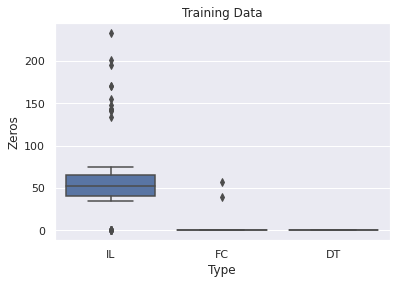

In [21]:
sns.boxplot(data = df_train, x='Type', y='Zeros').set(title="Training Data");

[Text(0.5, 1.0, 'Testing Data')]

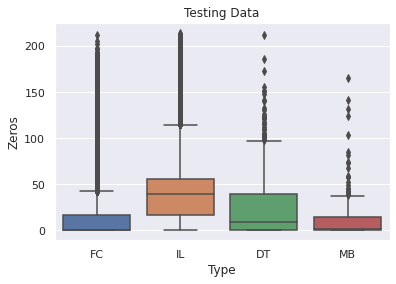

In [22]:
sns.boxplot(data = df_test, x='Type', y='Zeros').set(title="Testing Data")

The zero appears to be concentrated on the FC & DT data types.  This makes sense as food courts (FC) and drive thru (DT) wouldn't have certain stats such as parking spaces. The absence of mobile (MB) in the training set and the different in distribution between the train & test data may also present a future problem when estimating revenue on the test dat.

In [23]:
df_train.drop(columns=['Zeros'],inplace=True)
df_test.drop(columns=['Zeros'],inplace=True)

## Evaluate Columns with Zeros

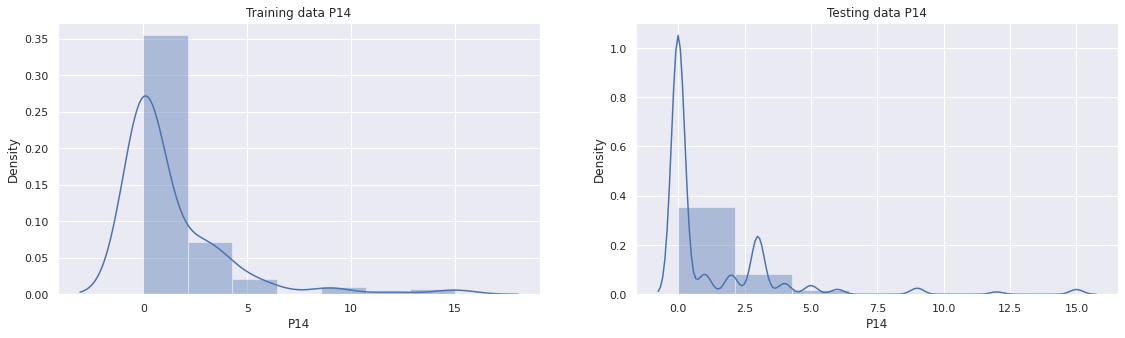

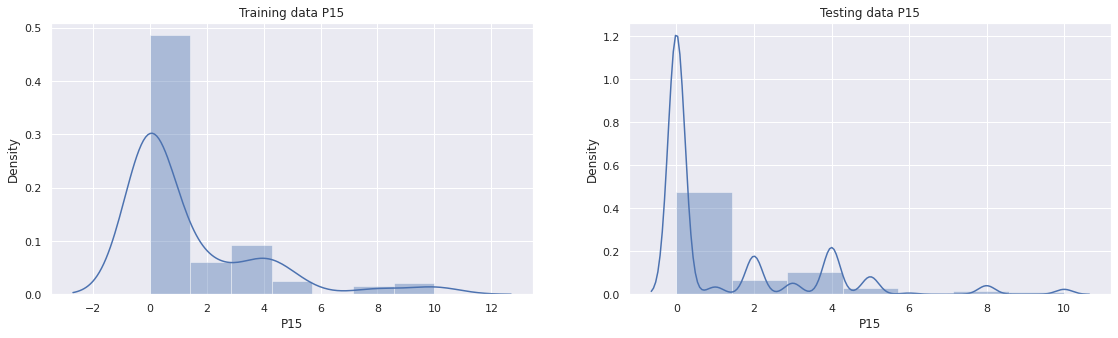

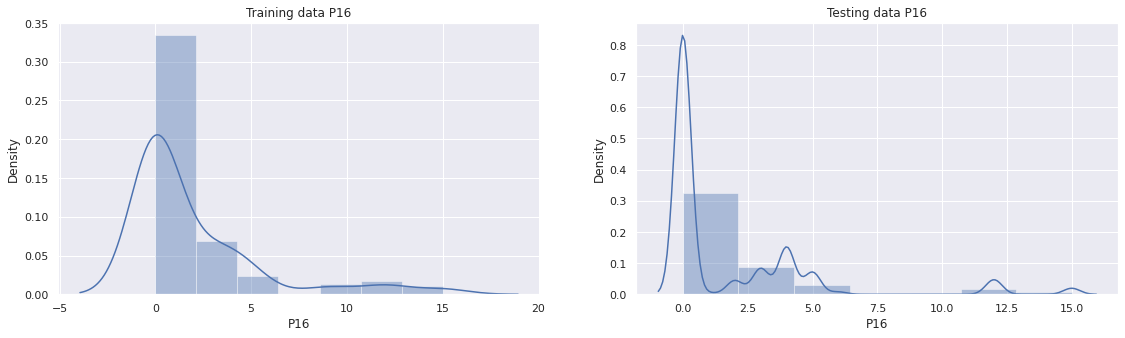

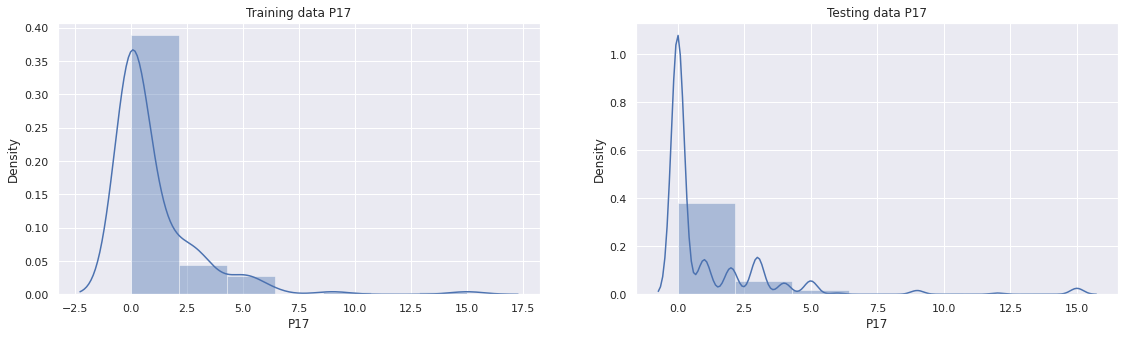

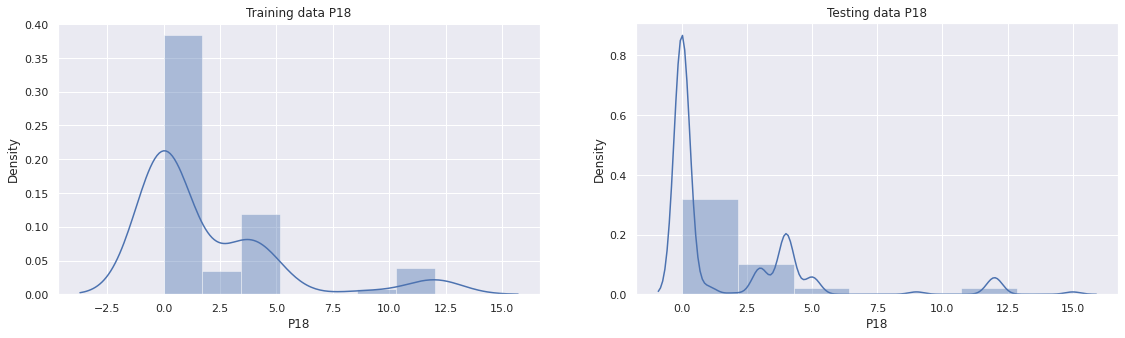

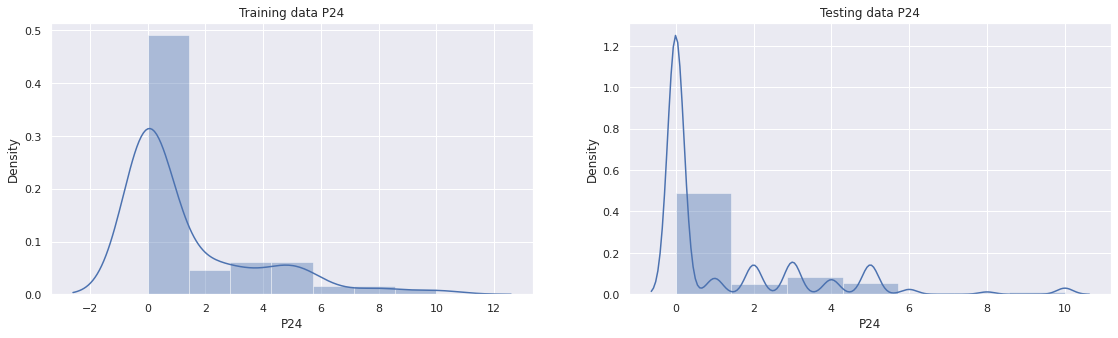

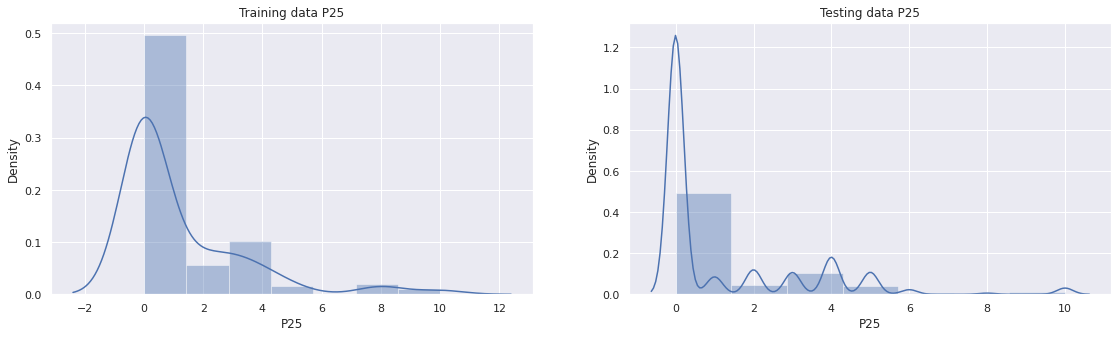

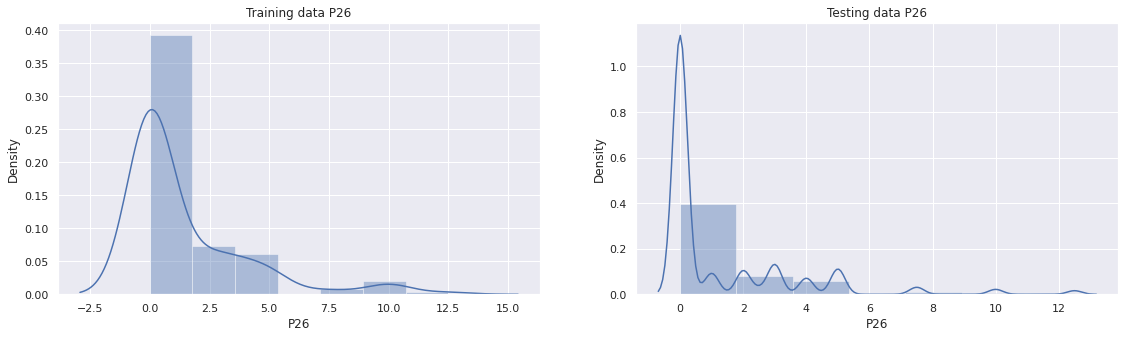

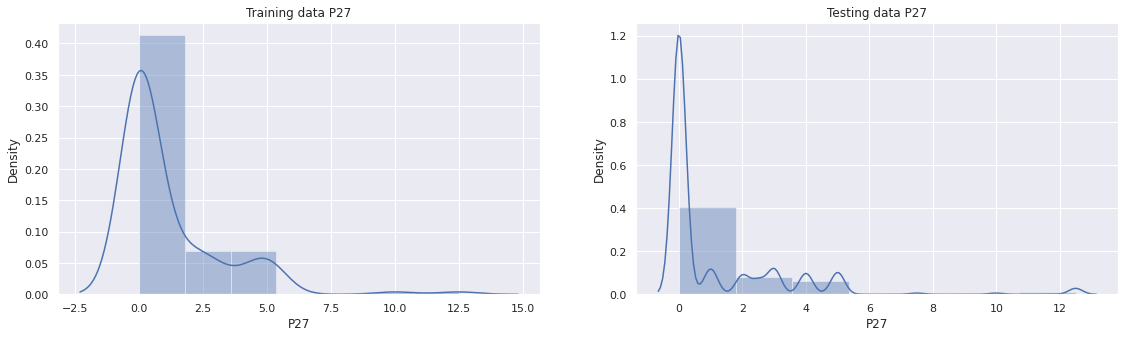

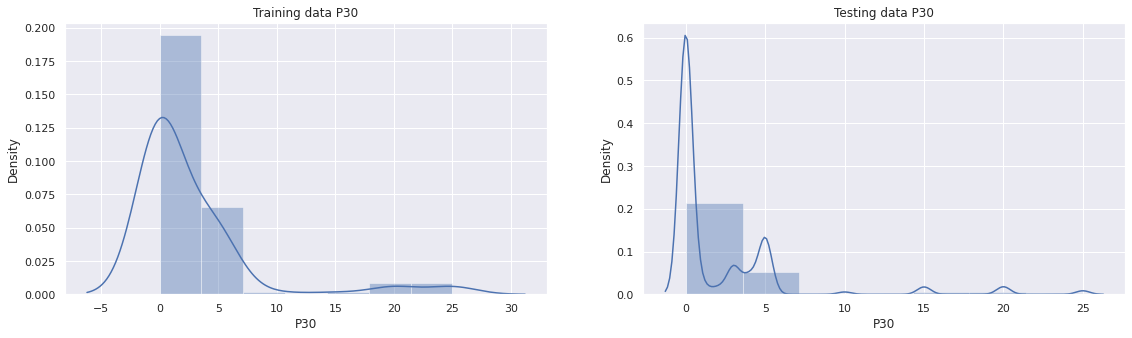

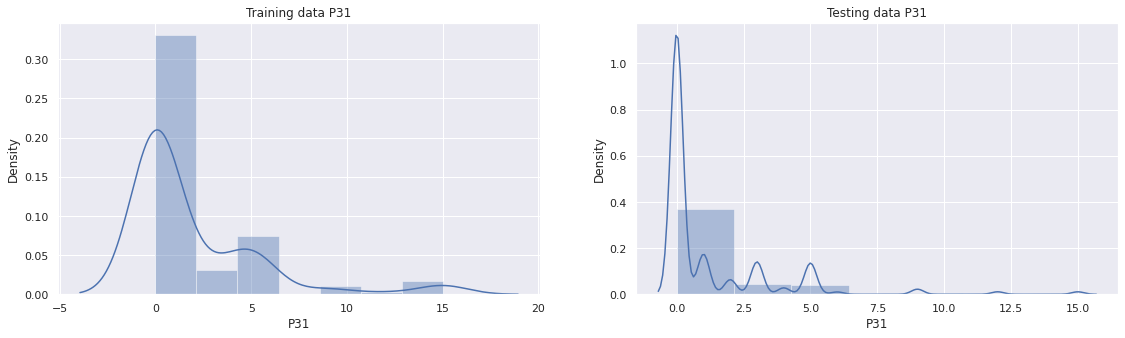

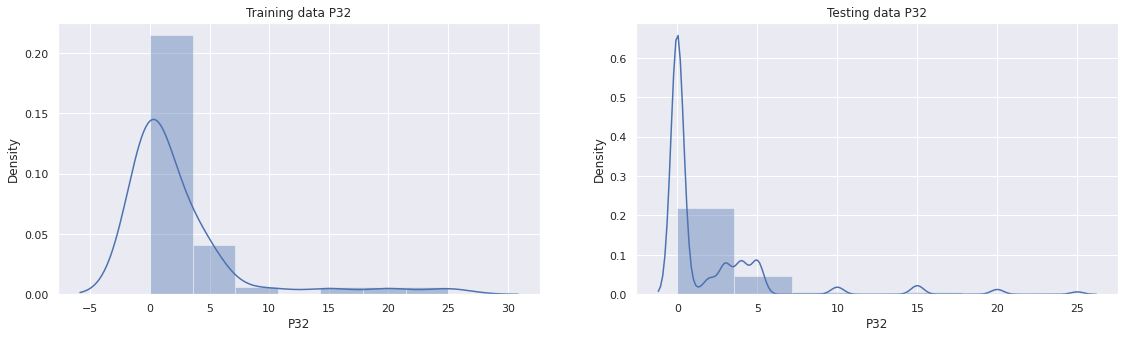

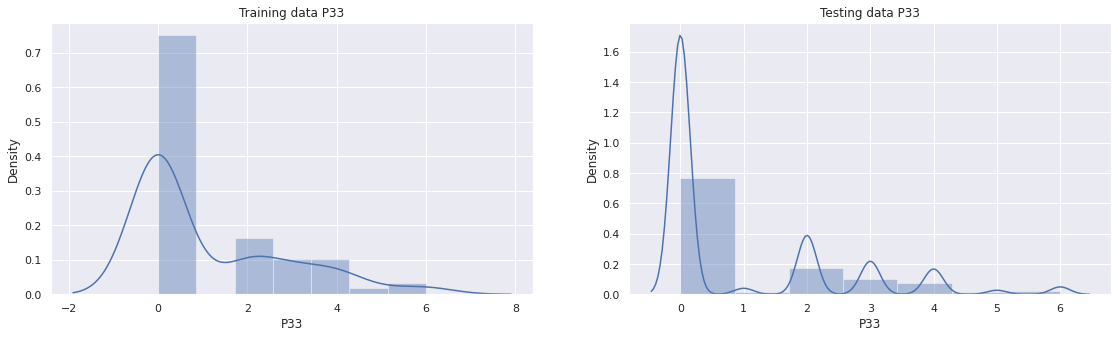

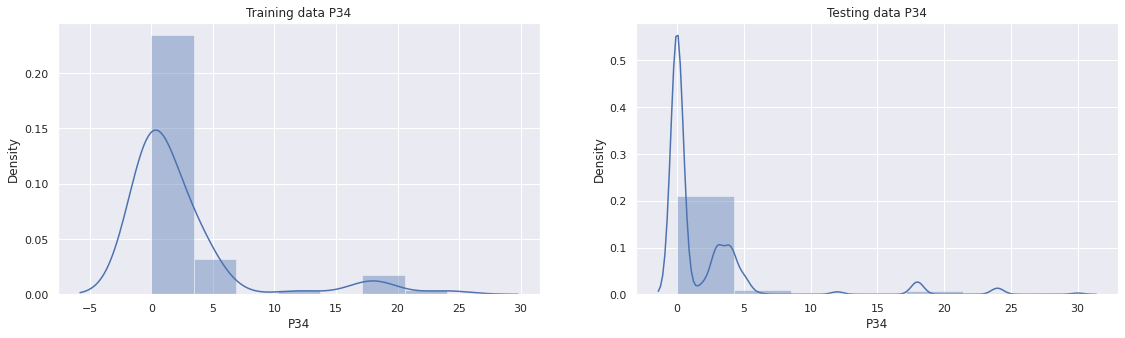

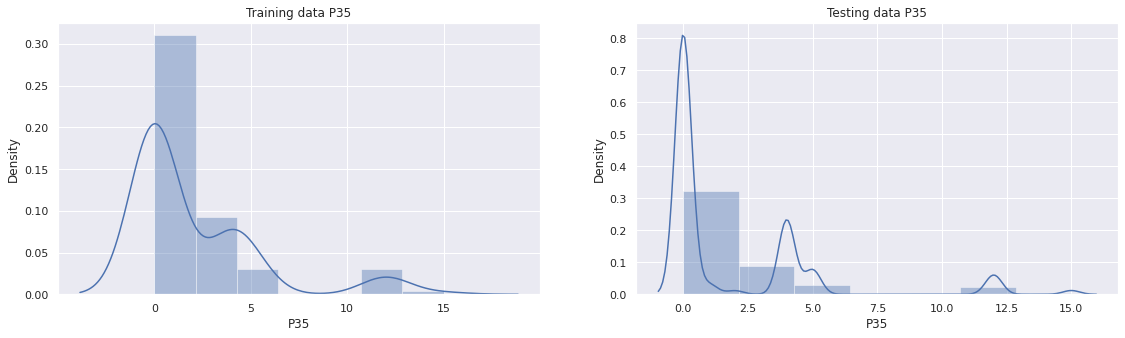

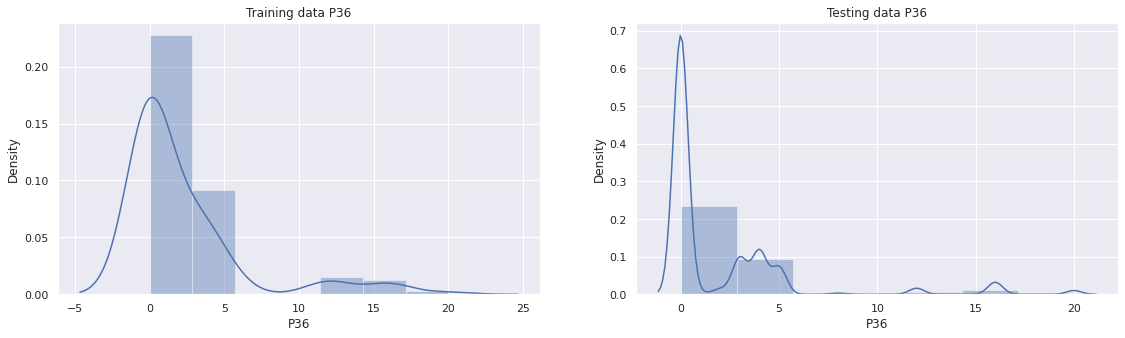

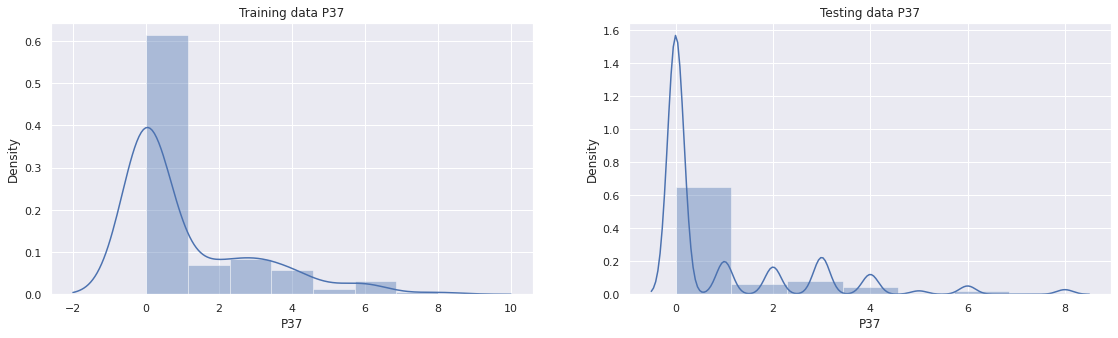

In [24]:
plt.rc('figure', max_open_warning = 0)
for i in PsZeros:
    fig, ax = plt.subplots(1,2, figsize=(19, 5))
    g1 = sns.distplot(df_train[i], ax=ax[0], bins = 7).set(title='Training data ' + i)#, kde=False);
    g2 = sns.distplot(df_test[i], ax=ax[1], bins = 7).set(title='Testing data ' + i)#, kde=False);
    fig.show()

The test data even for the IL restaurant also contains zero and demonstrate variation from the training data. As we hope to use standard scaling to aid the regression analysis, solution selected is to merge the train and test datasets for scaling and resplit for analysis.

Conclussion is zero needs to be dropped and log normalization is unlikely to significantly aid the regression analysis.

#Replacing Zeros

The zero Ps (P14-P18, P24-P27 and P30-37) but only appear to be important for the IL restaurants.  Seperated the dataset into IL and Other types. Scale by replacing 0 with mean in the IL set, then z-score scale. For the other dataset set all zero Ps to 0 so they will have not impact on the future analysis. 

### merge files

In [25]:
df_merged = pd.concat([df_test, df_train], axis=0, ignore_index=True).copy()
df_merged.shape

(100137, 43)

In [26]:
df_merged.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,100137.0,4.993119e+04,2.890688e+04,0.0,24897.0,49931.0,74965.0,99999.0
P1,100137.0,4.087930e+00,2.813085e+00,1.0,2.0,3.0,4.0,15.0
P2,100137.0,4.428059e+00,1.428979e+00,1.0,4.0,5.0,5.0,7.5
P3,100137.0,4.215465e+00,8.424524e-01,0.0,4.0,4.0,4.0,7.5
P4,100137.0,4.395992e+00,1.035796e+00,2.0,4.0,4.0,5.0,7.5
P5,100137.0,1.989614e+00,1.065518e+00,1.0,1.0,2.0,2.0,8.0
P6,100137.0,2.882551e+00,1.532502e+00,1.0,2.0,2.0,4.0,10.0
P7,100137.0,5.300678e+00,2.178739e+00,1.0,5.0,5.0,5.0,10.0
P8,100137.0,4.931304e+00,1.718699e+00,1.0,4.0,5.0,5.0,10.0
P9,100137.0,5.251645e+00,1.702825e+00,4.0,4.0,5.0,5.0,10.0


In [27]:
for i in PsZeros:
  df_merged[i][df_merged[i] == 0] = np.nan

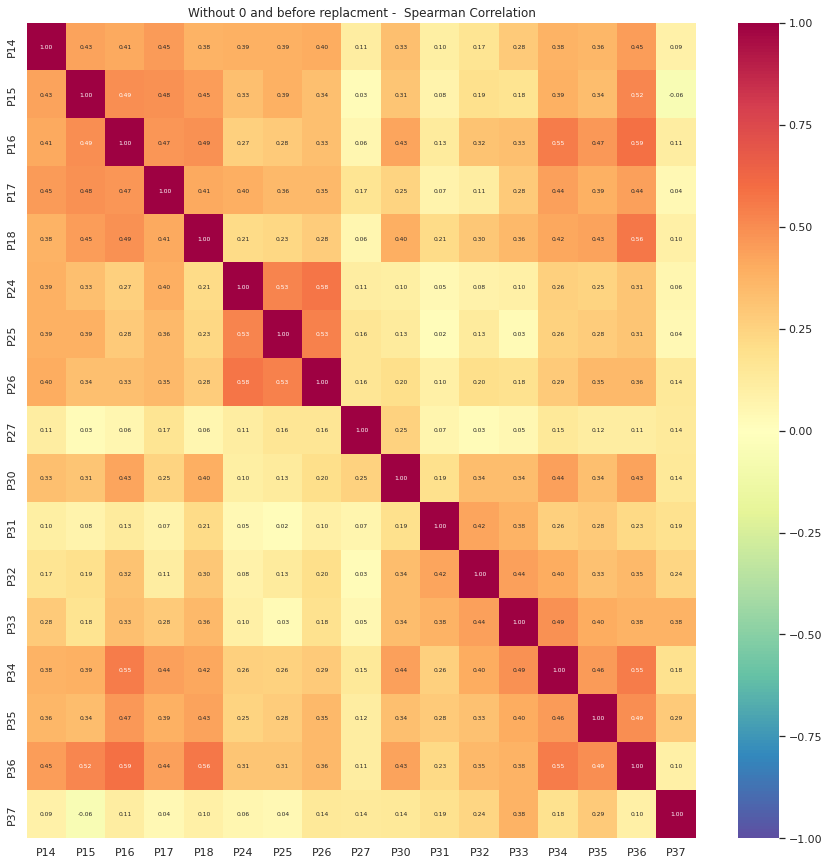

In [28]:
plt.figure(figsize=(15,15))
sns.heatmap(data = df_merged[PsZeros][df_merged["Type"] == "IL"].corr(method = "spearman"), vmin = -1, vmax = 1, 
            annot = True, cmap ='Spectral_r', annot_kws={"size":6},fmt = ".2f").set(title='Without 0 and before replacment -  Spearman Correlation');

The Ps column with zero appears not to be co-related.

In [29]:
z_mean = df_merged[PsZeros][df_merged['Type'] == 'IL'].mean()
z_mean

P14    3.798133
P15    3.840323
P16    5.200834
P17    3.404802
P18    5.036327
P24    3.604858
P25    3.579174
P26    3.734913
P27    3.381076
P30    6.194776
P31    3.569678
P32    5.766413
P33    2.900051
P34    6.194480
P35    5.451445
P36    5.779656
P37    2.791606
dtype: float64

In [30]:
for i in PsZeros:
  df_merged[i][df_merged['Type'] == 'IL'] = df_merged[i][df_merged['Type'] == 'IL'].fillna(df_merged[i][df_merged['Type'] == 'IL'].mean())
  df_merged[i][df_merged['Type'] != 'IL'] = df_merged[i][df_merged['Type'] == 'IL'].mean()

Scale the Ps Zeros column for the IL type and replace the FC, MB & DT with the mean which with standard scaling will become 0

## Pearson & Spearmen relationships

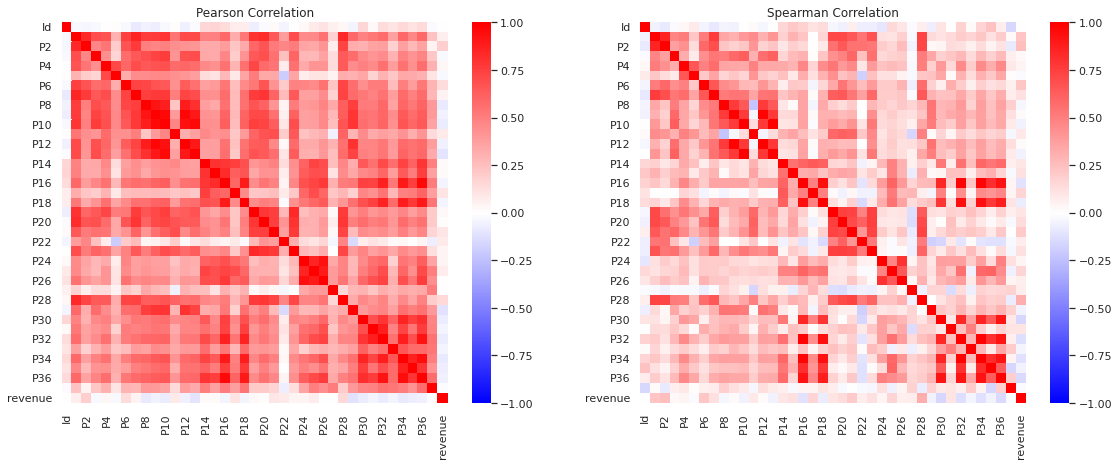

In [31]:
fig, ax = plt.subplots(1,2, figsize=(19, 7))
g1 = sns.heatmap(data = df_merged[df_merged['revenue'] >=0].corr(method = "pearson"), vmin = -1, vmax = 1, annot = False, cmap ='bwr', ax=ax[0]).set(title='Pearson Correlation');
g2 = sns.heatmap(data = df_merged[df_merged['revenue'] >=0].corr(method = "spearman"), vmin = -1, vmax = 1, annot = False, cmap ='bwr', ax=ax[1]).set(title='Spearman Correlation');
fig.show()

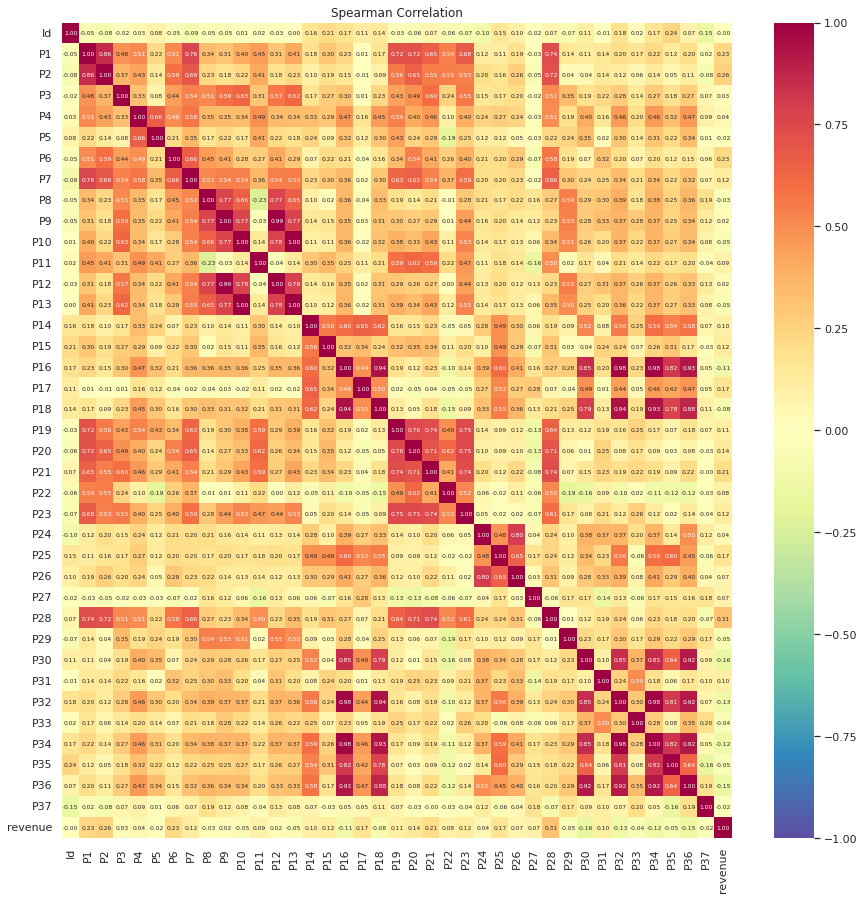

In [32]:
plt.figure(figsize=(15,15))
sns.heatmap(data = df_merged[df_merged['revenue'] >=0].corr(method = "spearman"), vmin = -1, vmax = 1, 
            annot = True, cmap ='Spectral_r', annot_kws={"size":6},fmt = ".2f").set(title='Spearman Correlation after the zero have been replaced');

The Ps attributes have a degree of intra-dependents (P9 with P12, P10 with P13) but while P16, P18, P32, P34 appear to match with P36 these are all fields with significant zeros. Before doing additional analysis create categorical data from object columns.

In [34]:
df_merged['P9-12'] = (df_merged['P9'] + df_merged['P12'])/2
df_merged['P10-13'] = (df_merged['P10'] + df_merged['P13'])/2
df_merged.drop(columns=['P9','P10','P12','P13'],inplace=True)

In [ ]:
cols_cat

In [36]:
df_merged['Group_cat'] = 0
df_merged['Group_cat'][df_merged['City Group'] == "Big Cities"] = 1
df_merged['Group_cat'] = df_merged['Group_cat'].astype("int64")
df_merged['Type_cat'] = 0
df_merged['Type_cat'][df_merged['Type'] == "IL"] = 1
df_merged['Type_cat'] = df_merged['Type_cat'].astype("int64")

##City Population

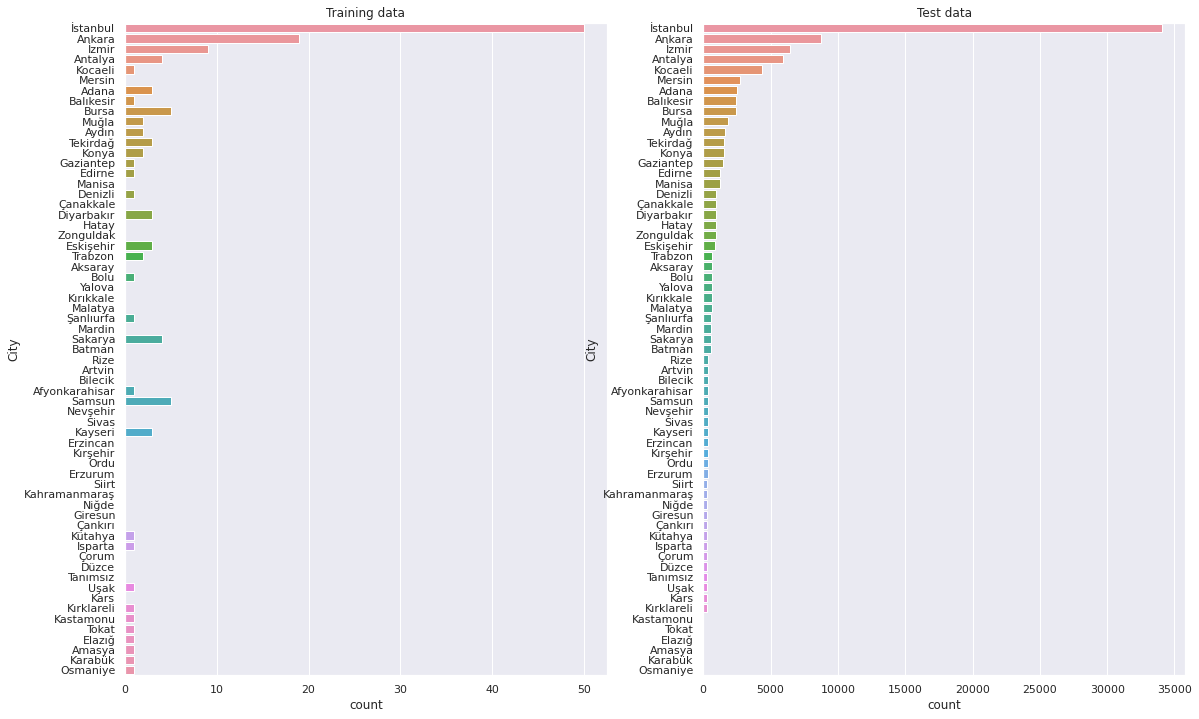

In [37]:
fig, ax = plt.subplots(1,2, figsize=(19, 12))
large_to_small = df_merged.groupby('City').size().sort_values().index[::-1]
g1 = sns.countplot(data = df_train, y = "City", order=large_to_small, ax=ax[0]).set(title='Training data')
g2 = sns.countplot(data = df_test, y = "City",order=large_to_small, ax=ax[1]).set(title='Test data')
fig.show()

In [38]:
print("Unique cities in training set", df_train['City'].nunique(), "and in the test set", df_test['City'].nunique(),'\n')
cities = df_test['City'].unique()
cities

Unique cities in training set 34 and in the test set 57 



array(['Niğde', 'Konya', 'Ankara', 'Kocaeli', 'Afyonkarahisar',
       'Eskişehir', 'Rize', 'İstanbul', 'Trabzon', 'Antalya', 'Muğla',
       'Düzce', 'Adana', 'Bursa', 'Aydın', 'Hatay', 'Denizli', 'İzmir',
       'Gaziantep', 'Samsun', 'Erzurum', 'Edirne', 'Balıkesir', 'Mersin',
       'Zonguldak', 'Malatya', 'Çanakkale', 'Kars', 'Bolu', 'Batman',
       'Bilecik', 'Giresun', 'Tekirdağ', 'Sivas', 'Kırıkkale', 'Mardin',
       'Erzincan', 'Manisa', 'Diyarbakır', 'Kahramanmaraş', 'Yalova',
       'Tanımsız', 'Sakarya', 'Kırşehir', 'Aksaray', 'Kayseri',
       'Nevşehir', 'Çorum', 'Ordu', 'Kırklareli', 'Şanlıurfa', 'Artvin',
       'Uşak', 'Kütahya', 'Siirt', 'Çankırı', 'Isparta'], dtype=object)

Significantly more cities in the test data than the train dataset along with a variation in the sampling of the smaller (other) cities.

Remove the unicode from the City names and replace with standard English.

In [39]:
s = pd.Series(df_merged['City'])

df_merged['CityEN'] = s.str.normalize('NFKD')\
       .str.encode('ascii', errors='ignore')\
       .str.decode('utf-8')

citiesEN = df_merged['CityEN'].unique()

In [40]:
print("The number of cities in the merged file ",df_merged['CityEN'].nunique())

The number of cities in the merged file  63


The final number of cites would indicate some of the smaller cities only exist in the training data. Next item is to import csv with Turkey city population source worldpopulationreview.com

In [41]:
filename = filepath + '/CityPopulation.csv'
print(filename)
df_city = pd.read_csv(filename)
df_city.head()

/content/drive/MyDrive/CDS_Course/project/CityPopulation.csv


,City,Population
0,Istanbul,14804116
1,Ankara,3517182
2,Izmir,2500603
3,Bursa,1412701
4,Adana,1248988


In [42]:
cityD = pd.Series(df_city.Population.values,index=df_city.City).to_dict()

Populate a column with the city populations

In [43]:
df_merged['City_Pop'] = df_merged['CityEN'].map(cityD) 
df_merged['City_Pop'][df_merged['City_Pop'] == 0] = np.nan
print("The number of cities that we don't have population",df_merged['City_Pop'].isna().sum().sum())

The number of cities that we don't have population 13708


To estimate population to the missing cities, check if the number of restaurant in a city can be used as an estimater.

In [44]:
resCount = df_merged.groupby(['CityEN'])['CityEN'].count()
resC = pd.Series(resCount).to_dict()
df_merged['resC'] = df_merged['CityEN'].map(resC) 

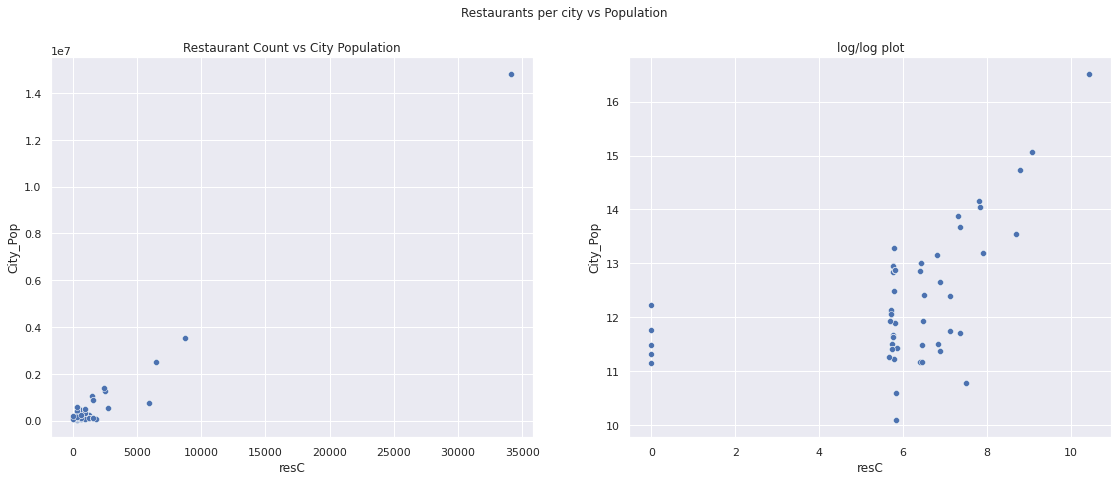

In [45]:
fig, ax = plt.subplots(1,2, figsize=(19, 7))
g1 = sns.scatterplot((df_merged["resC"]),(df_merged["City_Pop"]),ax=ax[0]).set(title='Restaurant Count vs City Population')
g2 = sns.scatterplot(np.log(df_merged["resC"]),np.log(df_merged["City_Pop"]),ax=ax[1]).set(title='log/log plot')
plt.suptitle('Restaurants per city vs Population');

Determine the relationship between number of restaurants and city size. Assume the best estimate is for zero restaurant to equate to zero population.

In [48]:
from sklearn.linear_model import LinearRegression
model_lr_rP = LinearRegression(fit_intercept=False)

# need to remove nan
df = pd.DataFrame({"X":df_merged['resC'],"Y":df_merged['City_Pop']})
df.dropna(inplace=True)

X = df.X.to_numpy()
X = X.reshape(-1,1)
Y = df.Y.to_numpy()
Y = Y.reshape(-1,1)

model_lr_rP.fit(X, Y)
rPSlope = model_lr_rP.coef_
print(model_lr_rP.intercept_,model_lr_rP.coef_)

0.0 [[431.15994563]]


In [49]:
from numpy.ma.core import arange
resL = arange(1,np.nanmax(df_merged['resC']),np.nanmax(df_merged['resC'])/50)
popL = resL * 431

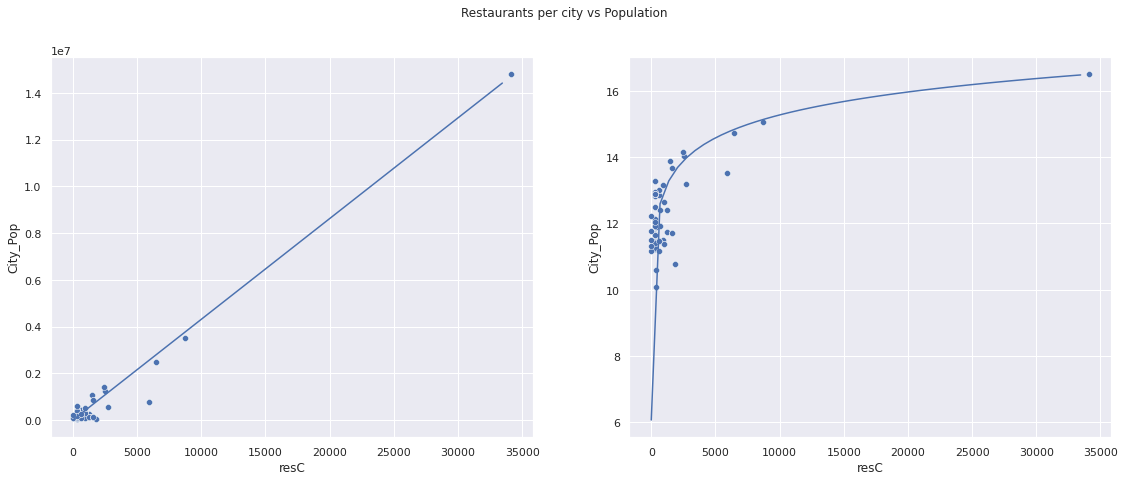

In [50]:
fig, ax = plt.subplots(1,2, figsize=(19, 7))
g1 = sns.scatterplot((df_merged["resC"]),(df_merged["City_Pop"]),ax=ax[0])
g1 = sns.lineplot((resL),(popL), ax= ax[0])
g2 = sns.scatterplot((df_merged["resC"]),np.log(df_merged["City_Pop"]),ax=ax[1])
g2 = sns.lineplot((resL),np.log(popL), ax = ax[1])
plt.suptitle('Restaurants per city vs Population');

Add an estimated population to each city that presently is nan

In [51]:
df_merged['City_Pop'] = df_merged['City_Pop'].fillna(df_merged['resC']*431)
print("The number of cities that now don't have a population estimate is",df_merged['City_Pop'].isna().sum().sum())

The number of cities that now don't have a population estimate is 0


Create the log of the city population

In [52]:
df_merged['City_Pop_log'] = np.log(df_merged['City_Pop'])

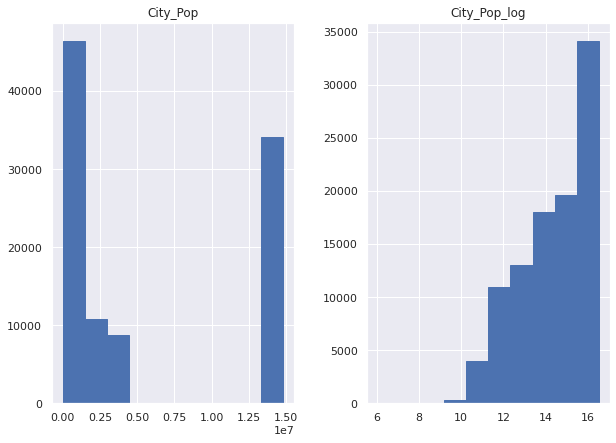

In [53]:
fplot = ['City_Pop','City_Pop_log']
df_merged[fplot].hist(figsize=(10,7),edgecolor='b');